In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import sys
sys.path.append('..')

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import cv2
from opencv_camera import bgr2gray, gray2bgr
from helpers import SaveVideo
from tqdm.notebook import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from ipywidgets import Video

import pickle
from collections import deque, namedtuple
from slurm.files import rm

In [37]:
with open("../../videos/flow-stereo.pkl", "rb") as fd:
    frames = pickle.load(fd)
    
print(f">> Loaded {len(frames)} images")

>> Loaded 167 images


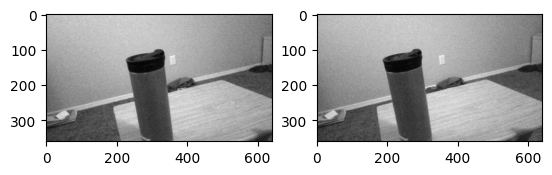

In [21]:
leftimgs = []
rightimgs = []

r,c = frames[0].shape[:2]

f = max(r,c)  # focal length is a function of image size in pixels
K = np.array([
    [f,0,c//2],
    [0,f,r//2],
    [0,0,1]
])

for im in frames:
    im = cv2.rotate(im, cv2.ROTATE_180)
    leftimgs.append(im[:,:c//2])
    rightimgs.append(im[:,c//2:])
    
plt.subplot(121); plt.imshow(leftimgs[0], cmap="gray")
plt.subplot(122); plt.imshow(rightimgs[0], cmap="gray");

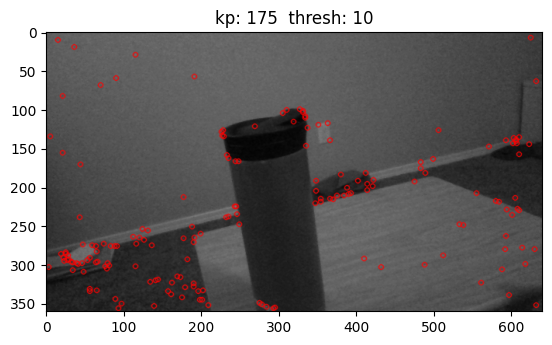

In [55]:
thresh = dict(threshold=10, nonmaxSuppression=True)
fast = cv2.FastFeatureDetector_create(**thresh)

im = leftimgs[0]
im = gray2bgr(im)

flags = 0 #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
kp = fast.detect(im)
im = cv2.drawKeypoints(im,kp,None,(255,0,0),flags)
plt.imshow(im)
plt.title(f"kp: {len(kp)}  thresh: {thresh['threshold']}");

19.0


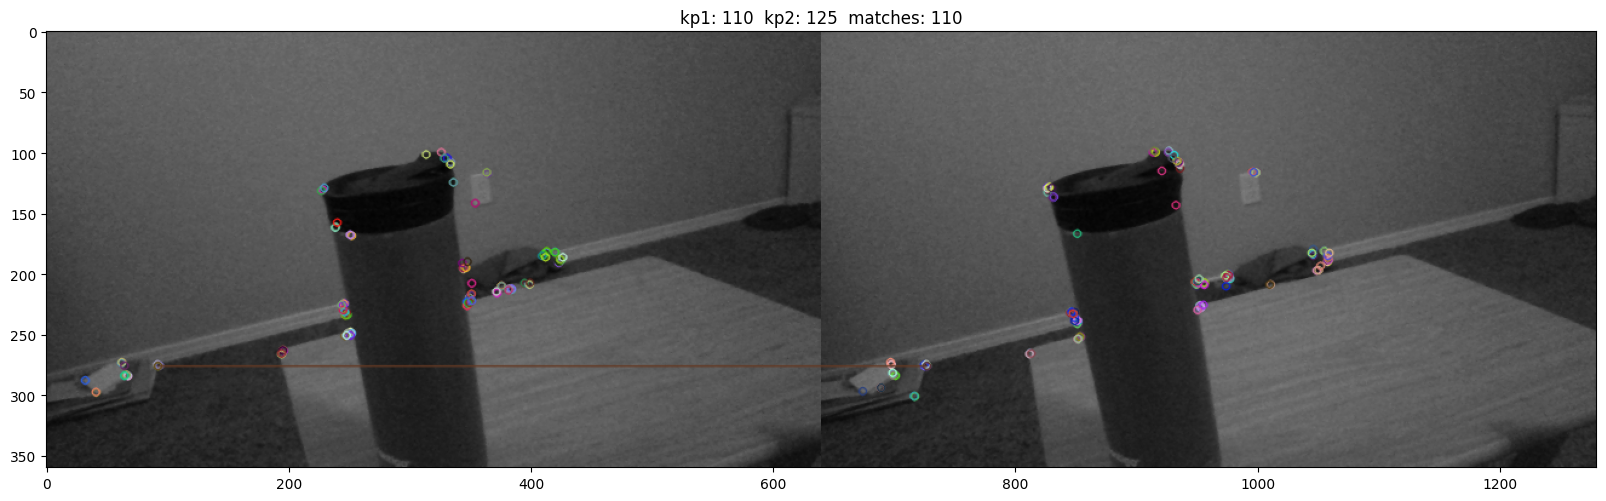

In [97]:
def draw(left, right):
    # thresh = dict(threshold=10, nonmaxSuppression=True)
    # fast = cv2.FastFeatureDetector_create(**thresh)
    # Detect ORB features and compute descriptors.
    MAX_FEATURES = 1000
    GOOD_MATCH_PERCENT = 1.0
    orb = cv2.ORB_create(MAX_FEATURES)
    
    left = gray2bgr(left)
    right = gray2bgr(right)

    # kp1 = fast.detect(left)
    # kp2 = fast.detect(right)
    kp1, descriptors1 = orb.detectAndCompute(left, None)
    kp2, descriptors2 = orb.detectAndCompute(right, None)
    
    # Match features.
    matcher = cv2.DescriptorMatcher.create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))
    
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    key = 12
    print(matches[key].distance)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    
    flags = 0 #cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    im = cv2.drawMatches(left,kp1,right,kp2,[matches[key]],None)
    
    plt.figure(figsize=(20,10))
    plt.imshow(im)
    plt.title(f"kp1: {len(kp1)}  kp2: {len(kp2)}  matches: {len(matches)}");
    
i = 15
draw(leftimgs[i],rightimgs[i])

In [96]:
matches

NameError: name 'matches' is not defined

In [106]:
# This is just a collection of different feature detectors
# def FAST(im):
#     fast = cv2.FastFeatureDetector_create()
#     fast.setNonmaxSuppression(True)
#     fast.setThreshold(5)  # 20
#     # find and draw the keypoints
#     keypoints = fast.detect(im)
#     keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')  # int?
    
    
#     # keypoints = sorted(kp1, key = lambda x:x.response, reverse=True)[:numCorners]
#     # keypoints = np.array([k.pt for k in keypoints], dtype='int')
    
#     return keypoints

# def createfeatureDetection():
#     thresh = dict(threshold=5, nonmaxSuppression=True);
#     fast = cv2.FastFeatureDetector_create(**thresh)
#     return fast

def featureTrack(new_gray,old_gray,p0):
    """
    Given some initial feature (p0) find the new location of those 
    features in the new image. All images are grayscale.
    """
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (10,10),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # good points have st==1, so weed out the bad
    new = p0[st==1]
    old = p1[st==1]
    
    p1 = np.array([[k] for k in new],dtype=np.float32)
    p0 = np.array([[k] for k in old],dtype=np.float32)

    return p0, p1

def stereo_match_feature(left_img, right_img, patch_radius, keypoints, min_disp, max_disp):
    # in case you want to find stereo match by yourself
    h, w = left_img.shape
    num_points = keypoints.shape[0]

    # Depth (or disparity) map
    depth = np.zeros(left_img.shape, np.uint8)
    output = np.zeros(keypoints.shape, dtype='int')
    all_index = np.zeros((keypoints.shape[0],1), dtype='int').reshape(-1)

    r     = patch_radius
    # patch_size = 2*patch_radius + 1;

    for i in range(num_points):

        row, col = keypoints[i,0], keypoints[i,1]
        # print(row, col)
        best_offset = 0;
        best_score = float('inf');

        if (row-r < 0 or row + r >= h or col - r < 0 or col + r >= w): continue

        left_patch = left_img[(row-r):(row+r+1), (col-r):(col+r+1)] # left imag patch

        all_index[i] = 1

        for offset in range(min_disp, max_disp+1):

            if (row-r) < 0 or row + r >= h or  (col-r-offset) < 0 or (col+r-offset) >= w: continue

            diff  = left_patch - right_img[(row-r):(row+r+1), (col-r-offset):(col+r-offset+1)]
            sum_s = np.sum(diff**2)

            if sum_s < best_score:
                best_score = sum_s
                best_offset = offset

        output[i,0], output[i,1] = row,col-best_offset

    return output, all_index

def extract_keypoints_surf(img1, img2, K, baseline, refPoints = None):
    # detector = cv2.SURF(400)
    # detector = createfeatureDetection()
    # detector = cv2.ORB_create(500) # num features
    # detector = cv2.xfeatures2d_SURF.create(hessianThreshold=400)
    kp1, desc1 = detector.detectAndCompute(img1, None)
    kp2, desc2 = detector.detectAndCompute(img2, None)

    # FLANN parameters
    # FLANN_INDEX_KDTREE = 1
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict()   # or pass empty dictionary
    # flann = cv2.FlannBasedMatcher(index_params,search_params)
    # matches = flann.knnMatch(desc1,desc2,k=2)
    
    
    matcher = cv2.DescriptorMatcher.create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(desc1, desc2, None))
    
    print(len(matches))

    # ratio test as per Lowe's paper
    match_points1, match_points2 = [], []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            match_points1.append(kp1[m.queryIdx].pt)
            match_points2.append(kp2[m.trainIdx].pt)

    p1 = np.array(match_points1).astype(float)
    p2 = np.array(match_points2).astype(float)

    if refPoints is not None:
        mask = removeDuplicate(p1, refPoints)
        p1 = p1[mask,:]
        p2 = p2[mask,:]

    # 3x4 homogenous matrix for left/right camera
    M_left = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
    M_rght = K.dot(np.hstack((np.eye(3), np.array([[-baseline,0, 0]]).T)))
    # rearrange to make function work
    p1_flip = np.vstack((p1.T,np.ones((1,p1.shape[0]))))
    p2_flip = np.vstack((p2.T,np.ones((1,p2.shape[0]))))
    # reconstruct 3d points from camera matrices and points, returns 4xN pts (homogenous)
    P = cv2.triangulatePoints(M_left, M_rght, p1_flip[:2], p2_flip[:2])
    # these are 4d points, convert to 3d by dividing by the last element
    P = P/P[3]
    pts_3d = P[:3]

    return pts_3d.T, p1


def featureTracking(img_1, img_2, p1, world_points):
    # use KLT tracker
    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    st = st.reshape(st.shape[0])
    # find good one
    pre = p1[st==1]
    p2 = p2[st==1]
    w_points = world_points[st==1]  # ??????

    return w_points, pre,p2


def playImageSequence(limgs, rimgs, K, baseline):
    '''
        different ways to initialize the query points and landmark points
        you can specify the keypoints and landmarks
        or you can inilize_3D with FAST corner points, then stere match and 
        then generate 3D points, but not so accurate
        or you can use the OPENCV feature extraction and matching functions
    '''
    detector = createfeatureDetection()
    
    ret_pos = []
    left_img, right_img = limgs[0], rimgs[0]

    points, p1 = extract_keypoints_surf(left_img, right_img, K, baseline)
    p1 = p1.astype('float32')

    pnp_objP = np.expand_dims(points, axis = 2)
    pnp_p1   = np.expand_dims(p1, axis = 2).astype(float)

    # reference
    reference_img = left_img
    reference_2D  = p1
    landmark_3D   = points

    # _, rvec, tvec = cv2.solvePnP(pnp_objP, pnp_p1, K, None)

    for i, (left_img, right_img) in enumerate(zip(limgs, rimgs)):
        if i % 20 == 0:
            print('image: ', i)

        # track points through left image
        landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(
            reference_img, 
            left_img, 
            reference_2D,  
            landmark_3D)
        # print(len(landmark_3D), len(valid_land_mark))

        pnp_objP = np.expand_dims(landmark_3D, axis = 2)
        pnp_cur  = np.expand_dims(tracked_2Dpoints, axis = 2).astype(float)

        # try to estimate object pose given current image points
        _, rvec, tvec, inliers = cv2.solvePnPRansac(pnp_objP , pnp_cur, K, None)

        # update the new reference_2D
        reference_2D = tracked_2Dpoints[inliers[:,0],:]
        landmark_3D  = landmark_3D[inliers[:,0],:]

        # retrieve the rotation matrix
        rot,_ = cv2.Rodrigues(rvec)
        tvec = -rot.T.dot(tvec)     # coordinate transformation, from camera to world

        inv_transform = np.hstack((rot.T,tvec)) # inverse transform

        inliers_ratio = len(inliers)/len(pnp_objP) # the inlier ratio
#         print('inliers ratio: ',inliers_ratio)

        # re-obtain the 3 D points if the conditions satisfied
        # calculate distance tracked keypoints have moved
        if (inliers_ratio < 0.9 or len(reference_2D) < 50):
            # initiliazation new landmarks
            
            # landmark_3D, reference_2D = initiliazatize_3D_points(curImage, 
            #   curImage_R, K, baseline)
            # reference_2D = np.fliplr(reference_2D).astype('float32')
            
            landmark_3D_new, reference_2D_new = extract_keypoints_surf(
                left_img,   #curImage, 
                right_img,  # curImage_R, 
                K, 
                baseline, 
                reference_2D)
            # ???
            reference_2D_new = reference_2D_new.astype('float32')
            landmark_3D_new = inv_transform.dot(
                np.vstack((landmark_3D_new.T, np.ones((1,landmark_3D_new.shape[0]))))
            )
            valid_matches = landmark_3D_new[2,:] >0
            landmark_3D_new = landmark_3D_new[:,valid_matches]

            reference_2D = np.vstack((reference_2D, reference_2D_new[valid_matches,:]))
            landmark_3D =  np.vstack((landmark_3D, landmark_3D_new.T))
#         else:
#             print("*** failed conditions ***")

        reference_img = left_img
        ret_pos.append((tvec[0], tvec[2]))
    
    return ret_pos

In [107]:

baseline = 0.54
pts = playImageSequence(leftimgs, rightimgs, K, baseline)

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1029: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'
